In [1]:
import dendrogram

In [2]:
%matplotlib inline
import networkx as nx

In [3]:
G = nx.karate_club_graph()

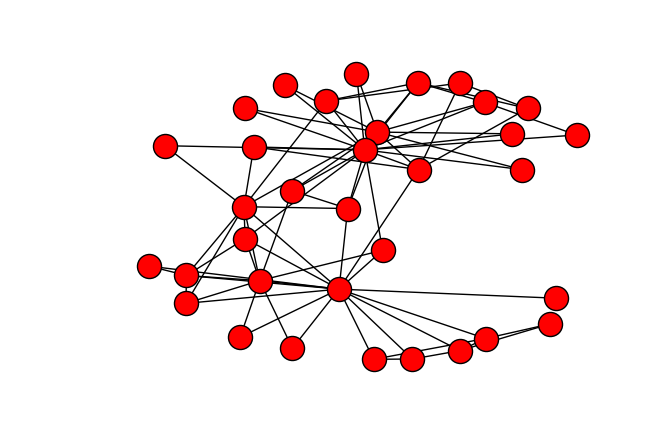

In [4]:
nx.draw(G)

In [5]:
G.node[0]

{'club': 'Mr. Hi'}

In [6]:
{G.node[n]['club'] for n in G.nodes_iter()}

{'Mr. Hi', 'Officer'}

In [7]:
set(nx.get_node_attributes(G, 'club').values())

{'Mr. Hi', 'Officer'}

In [8]:
partition = {}
for n in G:
    if G.node[n]['club'] == 'Mr. Hi':
        partition_number = 0
    else:
        partition_number = 1
    partition[n] = partition_number

partition

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 1,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 1,
 15: 1,
 16: 0,
 17: 0,
 18: 1,
 19: 0,
 20: 1,
 21: 0,
 22: 1,
 23: 1,
 24: 1,
 25: 1,
 26: 1,
 27: 1,
 28: 1,
 29: 1,
 30: 1,
 31: 1,
 32: 1,
 33: 1}

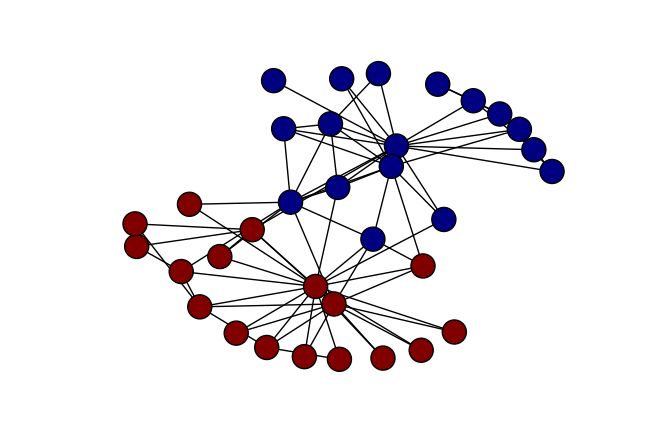

In [9]:
nx.draw(G, nodelist=partition.keys(), node_color=list(partition.values()))

In [10]:
def modularity(G, partition):
    m = sum(G.degree(weight='weight').values())
    
    #sum for all pairs i,j
    summation = 0
    for i in G.nodes_iter():
        for j in G.nodes_iter():
            if partition[i] == partition[j]:
                if G.has_edge(i, j):
                    A_ij = G.edge[i][j].get('weight', 1)
                else:
                    A_ij = 0
                
                k_i = G.degree(i, weight='weight')
                k_j = G.degree(j, weight='weight')
                
                summation += A_ij - k_i * k_j / m
                
    return summation / m

In [11]:
modularity(G, partition)

0.3582347140039433

In [12]:
from collections import Counter
Counter(partition.values())

Counter({0: 17, 1: 17})

In [13]:
import random
random_sample = set(random.sample(G.nodes(), 17))
partition = {}

for n in G.nodes_iter():
    if n in random_sample:
        partition[n] = 1
    else:
        partition[n] = 0
        
partition
modularity(G, partition)

-0.06122616699539739

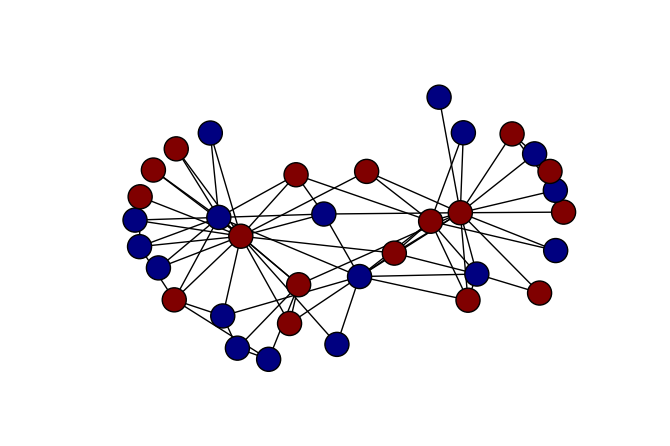

In [14]:
node_colors = [partition[n] for n in G.nodes_iter()]

nx.draw(G, node_color=node_colors)

In [15]:
def delta_q(G, partition, node_i, community):
    #Let's get the members of i's new community
    community_members = {node for node in G.nodes_iter() if partition[node] == community}
    #Adding this node to the community (note this is purely theoretical, not changing the actual graph)
    community_members.add(node_i)
    community_subgraph = G.subgraph(community_members)
    
    m2 = sum(G.degree(weight='weight').values())
    # This is internal degree... divide by two for the double counts on the edge
    s_in = sum(community_subgraph.degree(weight='weight').values()) / 2 
    # This is internal and external degree of a subgraph... divide by two for the double counts on edges
    s_tot = sum(G.degree(community_members, weight='weight').values()) / 2 
    
    k_i_in = community_subgraph.degree(node_i, weight='weight')
    k_i = G.degree(node_i, weight="weight")
    
    term_1 = ( (s_in + k_i_in) / m2
               - ((s_tot + k_i) / m2) ** 2 
             )
    term_2 = ( s_in / m2 
              - (s_tot / m2) ** 2 
              - (k_i / m2) ** 2
             )
    return term_1 - term_2

In [16]:
partition = {}
for n in G:
    if G.node[n]['club'] == 'Mr. Hi':
        partition_number = 0
    else:
        partition_number = 1
    partition[n] = partition_number


delta_q(G, partition, 0, 0)

0.04289940828402372

In [17]:
def optimize_modularity(G):
    #every node in it's own partition named after itself. Ex. 1 is in partition 1, 2 in partition 2, etc.
    partition = {n: n for n in G.nodes_iter()}
    
    MAX_ITERATIONS = 1000
    
    #This is like a while loop, but won't get stuck in infinite loop due to MAX_ITERATIONS
    for iteration in range(MAX_ITERATIONS):
        changed = False
        for i in G.nodes_iter():
            communities = set(partition.values())
            modularities = []
            
            for community in communities:
                this_delta_q = delta_q(G, partition, i, community)
                modularities.append((this_delta_q, community))
            
            delta_q_max, max_community = max(modularities)
            
            #partition takes a node label and turns it into a community label
            my_community = partition[i]
            
            if max_community != my_community:
                partition[i] = max_community
                changed = True
        
        if not changed:
            break
    
    return partition

In [18]:
optimize_modularity(G)

{0: 21,
 1: 21,
 2: 12,
 3: 12,
 4: 10,
 5: 16,
 6: 16,
 7: 12,
 8: 32,
 9: 12,
 10: 10,
 11: 21,
 12: 12,
 13: 12,
 14: 32,
 15: 32,
 16: 16,
 17: 21,
 18: 32,
 19: 21,
 20: 32,
 21: 21,
 22: 32,
 23: 25,
 24: 25,
 25: 25,
 26: 32,
 27: 25,
 28: 25,
 29: 32,
 30: 32,
 31: 25,
 32: 32,
 33: 32}

In [19]:
def aggregate_communities(G, partition):
    G2 = nx.Graph()
    G2.add_nodes_from(partition.values())
    
    for n in G2.nodes_iter():
        G2.node[n]['children'] = []
        
    for n in partition:
        community = partition[n]
        #G.node[n] returns dictionary of node attributes
        if 'children' in G.node[n]:
            G2.node[community]['children'].extend(G.node[n]['children'])
        else:
            G2.node[community]['children'].append(n)
            
    for i, j in G.edges_iter():
        weight = G.edge[i][j].get('weight', 1)
        c_i, c_j = partition[i], partition[j]
        
        try:
            G2.edge[c_i][c_j]['weight'] += weight
        except KeyError:
            G2.add_edge(c_i, c_j, weight=weight)
            
    return G2

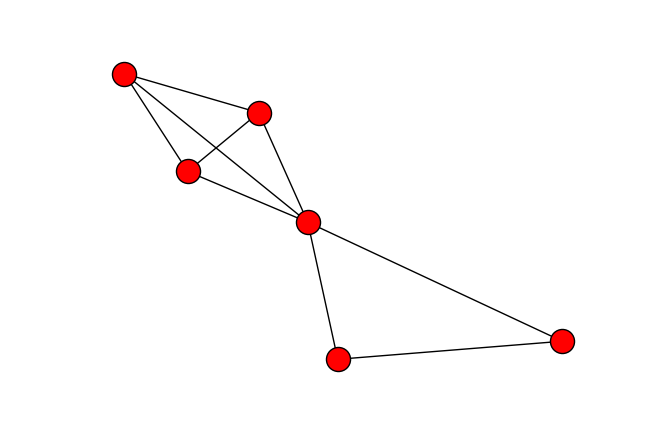

In [20]:
G1 = nx.karate_club_graph()
P1 = optimize_modularity(G1)
G2 = aggregate_communities(G1, P1)

nx.draw(G2)

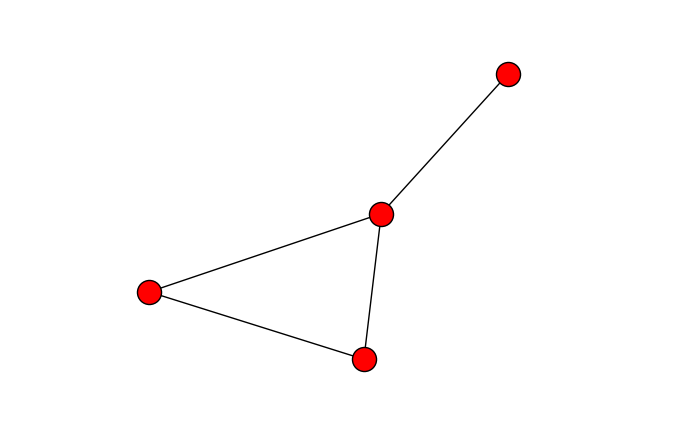

In [21]:
P2 = optimize_modularity(G2)
G3 = aggregate_communities(G2, P2)

nx.draw(G3)

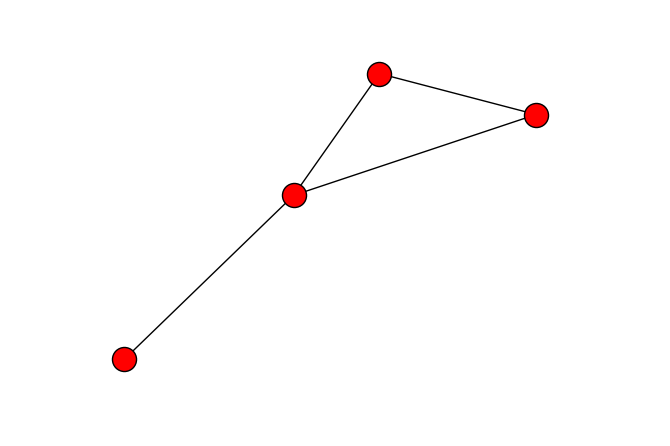

In [22]:
P3 = optimize_modularity(G3)
G4 = aggregate_communities(G3, P3)

nx.draw(G4)

In [23]:
P3

{10: 10, 12: 12, 25: 25, 32: 32}

In [24]:
all(k==v for k,v in P3.items())

True

In [25]:
nx.get_node_attributes(G3, 'children')

{10: [5, 6, 16, 4, 10],
 12: [0, 1, 11, 17, 19, 21, 2, 3, 7, 9, 12, 13],
 25: [23, 24, 25, 27, 28, 31],
 32: [8, 14, 15, 18, 20, 22, 26, 29, 30, 32, 33]}

In [26]:
partition = {}

#for each community
for c in G3:
    #for each node in that community's children
    for n in G3.node[c]['children']:
        partition[n] = c

partition

{0: 12,
 1: 12,
 2: 12,
 3: 12,
 4: 10,
 5: 10,
 6: 10,
 7: 12,
 8: 32,
 9: 12,
 10: 10,
 11: 12,
 12: 12,
 13: 12,
 14: 32,
 15: 32,
 16: 10,
 17: 12,
 18: 32,
 19: 12,
 20: 32,
 21: 12,
 22: 32,
 23: 25,
 24: 25,
 25: 25,
 26: 32,
 27: 25,
 28: 25,
 29: 32,
 30: 32,
 31: 25,
 32: 32,
 33: 32}

In [27]:
modularity(G, partition)

0.4188034188034182

In [28]:
#define a function to run the loop until the partition keys all equal partition values
#if all(k==v for k,v in P3.items()):
#     

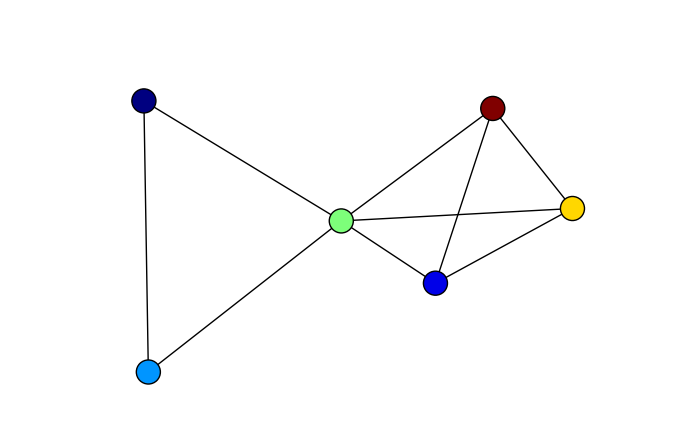

In [29]:
Graph = nx.karate_club_graph()
Partition = optimize_modularity(G1)
G2 = aggregate_communities(G1, P1)

node_colors = [Partition[n] for n in G2.nodes_iter()]

nx.draw(G2, node_color=node_colors)

In [30]:
partitions = []
graphs = []
count = 0
Graph = nx.karate_club_graph()
Partition = optimize_modularity(G1)

for i in range(100):
    if all(k==v for k,v in Partition.items()):
        graphs.append(Graph)
        partitions.append(Partition)
        break    
    else:
        graphs.append(Graph)
        partitions.append(Partition)
        Graph2 = aggregate_communities(Graph, Partition)
        Partition2 = optimize_modularity(Graph2)
        Graph = Graph2
        Partition = Partition2

In [31]:
partitions

[{0: 21,
  1: 21,
  2: 12,
  3: 12,
  4: 10,
  5: 16,
  6: 16,
  7: 12,
  8: 32,
  9: 12,
  10: 10,
  11: 21,
  12: 12,
  13: 12,
  14: 32,
  15: 32,
  16: 16,
  17: 21,
  18: 32,
  19: 21,
  20: 32,
  21: 21,
  22: 32,
  23: 25,
  24: 25,
  25: 25,
  26: 32,
  27: 25,
  28: 25,
  29: 32,
  30: 32,
  31: 25,
  32: 32,
  33: 32},
 {10: 10, 12: 12, 16: 10, 21: 12, 25: 25, 32: 32},
 {10: 10, 12: 12, 25: 25, 32: 32}]

In [32]:
graphs

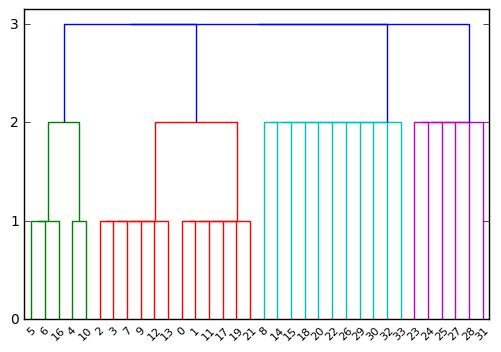

In [33]:
dendrogram.draw_louvain(partitions)